In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to read and process data
def read_and_process_data(path, experiments, metrics):
    full_summary_mean = {}
    full_summary_std = {}
    for experiment in experiments:
        summary_mean = {}
        summary_std = {}
        file_name = rename_experiments[experiment]
        global_values = pd.read_csv(f"{path}/{file_name}/metrics.csv")
        global_values.rename(columns={"f1 micro": "micro_f1", "f1 macro": "macro_f1", "auroc_weighted": "weighted_auroc", "auroc_macro": "macro_auroc"}, inplace=True)
        global_values_std = global_values.std()
        global_values_mean = global_values.mean()
        for metric in metrics:
            data = pd.read_csv(f"{path}/{file_name}/{metric}.csv")
            data_mean = data.mean()
            data_std = data.std()
            data_mean["global"] = global_values_mean[metric]
            data_std["global"] = global_values_std[metric]
            summary_mean[metric] = data_mean
            summary_std[metric] = data_std
        full_summary_mean[experiment] = summary_mean
        full_summary_std[experiment] = summary_std

    if "Capping and Filtering" in experiments:
        for metric in metrics:
            full_summary_mean["Capping and Filtering"][metric]["0-10"] = 0

    return full_summary_mean, full_summary_std

# Function to plot values
def plot_values(full_summary_mean, full_summary_std, experiments, metrics, groups, figsize=(14,5)):
    # Separate metrics into F1 scores and AUROC values
    f1_metrics = [metric for metric in metrics if 'f1' in metric]
    auroc_metrics = [metric for metric in metrics if 'auroc' in metric]

    # Function to plot individual group metrics
    def plot_group_metrics(metric, colors, indices, bar_width, num_experiments):
        fig, ax = plt.subplots(figsize=figsize)
        for i, experiment in enumerate(experiments):
            values = [full_summary_mean[experiment][metric].get(group, 0) for group in groups]
            errors = [full_summary_std[experiment][metric].get(group, 0) for group in groups]
            bar_positions = indices + i * bar_width
            ax.bar(bar_positions, values, bar_width, yerr=errors, label=experiment, capsize=5, color=colors[i], alpha=0.8, edgecolor='grey', error_kw={'alpha':0.6})
        ax.set_xlabel('Species Groups')
        ax.set_ylabel(metric)
        #ax.set_title(metric)
        ax.set_xticks(indices + bar_width * (num_experiments - 1) / 2)
        ax.set_xticklabels(groups)
        ax.legend(title='Experiment')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        # Set y-axis limit for AUROC metrics
        if 'auroc' in metric:
            ax.set_ylim(50, 100)
        plt.tight_layout()
        plt.show()

    # Function to plot global values
    def plot_global_values(ax, metrics, title, colors, legend=True):
        num_metrics = len(metrics)
        num_experiments = len(experiments)
        bar_width = 0.7 / num_experiments
        indices = np.arange(num_metrics)
        for i, experiment in enumerate(experiments):
            values = [full_summary_mean[experiment][metric]['global'] for metric in metrics]
            errors = [full_summary_std[experiment][metric]['global'] for metric in metrics]
            bar_positions = indices + i * bar_width
            ax.bar(bar_positions, values, bar_width, yerr=errors, label=experiment, capsize=5, color=colors[i], alpha=0.8, edgecolor='grey', error_kw={'alpha':0.6})
        ax.set_xlabel('Metrics')
        ax.set_ylabel('Global Values')
        ax.set_title(title)
        ax.set_xticks(indices + bar_width * (num_experiments - 1) / 2)
        ax.set_xticklabels(metrics)
        if legend:
            ax.legend(title='Experiment', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        # Set y-axis limit for AUROC metrics
        if any('auroc' in metric for metric in metrics):
            ax.set_ylim(50, 100)

    # Generate a color palette with as many colors as the number of experiments
    colors = plt.get_cmap('Set3').colors

    num_experiments = len(experiments)
    bar_width = 0.7 / num_experiments
    indices = np.arange(len(groups))

    # Plot individual group metrics
    for metric in metrics:
        plot_group_metrics(metric, colors, indices, bar_width, num_experiments)

    # Create a figure with two subplots side by side for global values
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    plot_global_values(axes[0], f1_metrics, 'Global F1', colors)
    plot_global_values(axes[1], auroc_metrics, 'Global AUROC', colors, legend=False)
    plt.tight_layout()
    plt.show()

# Function to create DataFrames for each metric
def create_metric_dataframes(full_summary_mean, metrics, groups, experiments):
    metric_dataframes = {}
    for metric in metrics:
        # Create an empty DataFrame with columns as groups and rows as experiments
        df = pd.DataFrame(index=experiments, columns=groups)
        for experiment in experiments:
            for group in groups:
                df.at[experiment, group] = full_summary_mean[experiment][metric][group]
        metric_dataframes[metric] = df
    return metric_dataframes


In [ ]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


In [2]:
# Define the experiments, metrics, and groups you want to compare
#loc_experiments = ["Presences_only_train", "po_none_to_1000", "po_10_to_1000","inverse_counts", "inverse_cluster_density", "thin_all", "thin_majority"]
loc_experiments = ["Baseline", "Capping", "Capping and Filtering","IFWRS", "SDWRS", "Thin All", "Thin Majority"]

#env_experiments = ["thin_bioclimatic"]
env_experiments = ["Thin Bioclimatic"]
#baseline_experiments = ["Presences_only_train", "po_10_to_1000"]
baseline_experiments = ["Baseline", "Capping and Filtering"]
#thinning_experiments = ["thin_all", "thin_majority", "thin_bioclimatic"]
thinning_experiments = ["Thin All", "Thin Majority", "Thin Bioclimatic"]
#sampling_experiments = ["inverse_counts", "inverse_cluster_density"]
sampling_experiments = ["IFWRS", "SDWRS"]
smote_experiments = ["SMOTE", "SMOTE+TOMEK"]
metrics = ["macro_f1", "macro_auroc"]  # Update with your actual metric names
groups = ["0-10", "10-20", "20-60", "60-100", "100-500", "500-1000", "1000-5000"]  # Update with your actual groups

# paths to experiments
loc_path = "/data/jribas/repos/sdm_sandbox/data/test_results/loc"
loc_env_path = "/data/jribas/repos/sdm_sandbox/data/test_results/loc_env"

In [39]:
xrename_experiments = {
    "Presences_only_train": "Baseline",
    "po_none_to_1000": "Capping",
    "po_10_to_1000": "Capping and Filtering",
    "inverse_counts": "IFWRS",
    "inverse_cluster_density": "SDWRS",
    "thin_all": "Thin All",
    "thin_majority": "Thin Majority",
    "thin_bioclimatic": "Thin Bioclimatic"
}

rename_experiments = {
    "Baseline": "Presences_only_train",
    "Capping": "po_none_to_1000",
    "Capping and Filtering": "po_10_to_1000",
    "IFWRS": "inverse_counts",
    "SDWRS": "inverse_cluster_density",
    "Thin All": "thin_all",
    "Thin Majority": "thin_majority",
    "Thin Bioclimatic": "thin_bioclimatic"
}

# daset sizes

In [30]:
sizes = pd.read_csv("data/dataset_sizes.csv")
cols = [
    'Name: loc_env_baseline_ds_Presences_only_train.csv_noise_None - train/dataset size',
    'Name: loc_env_baseline_ds_po_none_to_1000.csv_noise_None - train/dataset size',
    "Name: loc_env_baseline_ds_po_10_to_1000.csv - train/dataset size",
    'Name: loc_env_thin_all_dist_5 - train/dataset size',
    'Name: loc_env_thin_majority_dist_5 - train/dataset size',
    'Name: loc_env_thin_bioclimatic_dist_0.01 - train/dataset size',
    'Name: loc_env_smote_data/smote.csv - train/dataset size',
    'Name: loc_env_smote_data/smotetomek.csv - train/dataset size',
]
names = ["Baseline", "Capping", "Capping and Filetering",  "Complete Thinning", "Majority Thinning", "Bioclimatic Thinning", "SMOTE", "SMOTE+Tomek"]

# Create a dictionary for renaming
rename_dict = dict(zip(cols, names))
# Rename the columns using the dictionary
sizes = sizes[cols].rename(columns=rename_dict)
sizes.index= ["Dataset Size"]
sizes.T

,Dataset Size
Baseline,4908319
Capping,1977559
Capping and Filetering,1965051
Complete Thinning,2876815
Majority Thinning,2882281
Bioclimatic Thinning,4461424
SMOTE,5909987
SMOTE+Tomek,3122287


# loc (all experiments)

In [31]:
loc_experiments

['Baseline',
 'Capping',
 'Capping and Filtering',
 'IFWRS',
 'SDWRS',
 'Thin All',
 'Thin Majority']

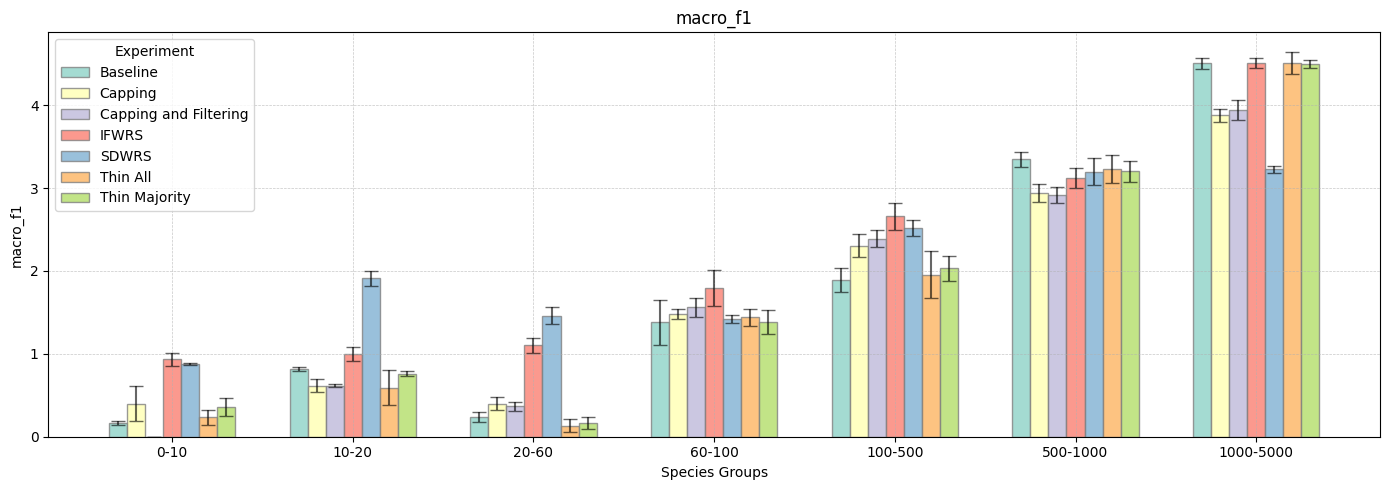

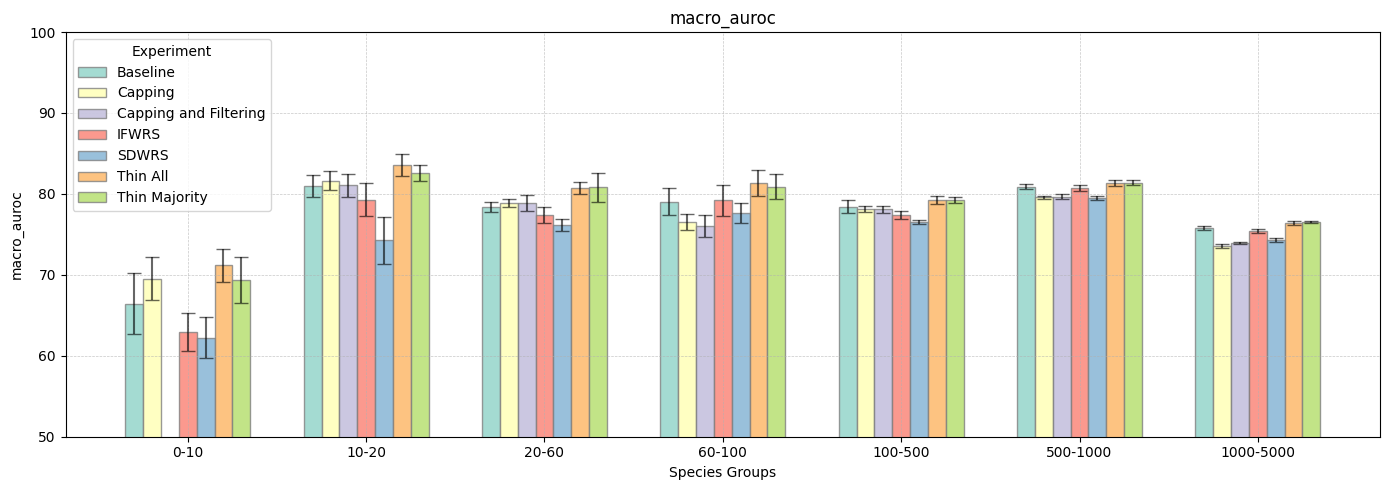

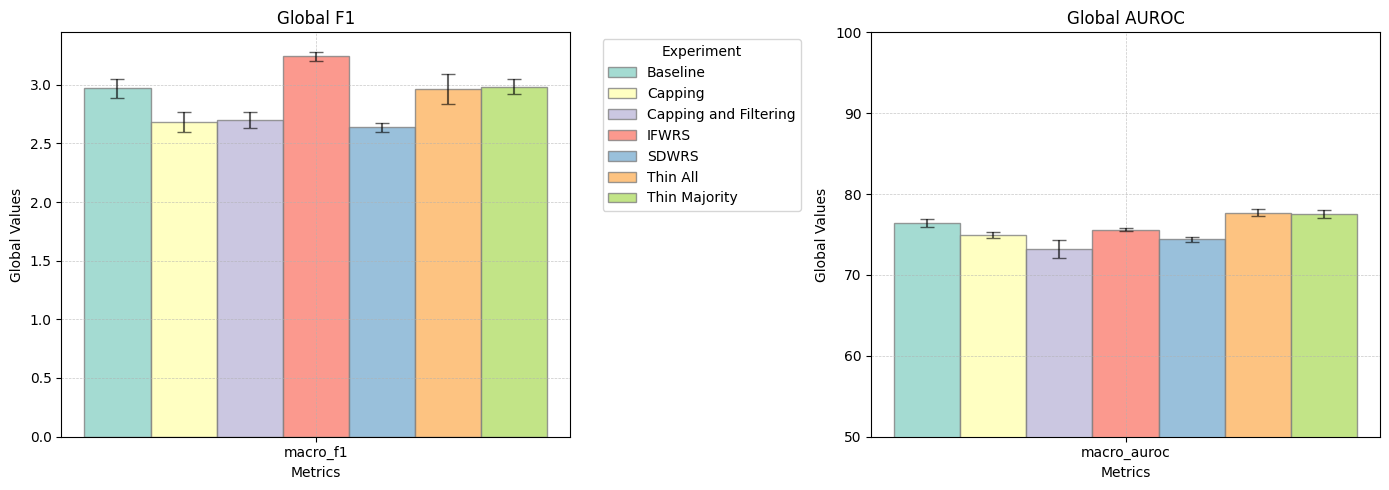

DataFrame for macro_f1:


,0-10,10-20,20-60,60-100,100-500,500-1000,1000-5000,global
Baseline,0.168,0.818,0.238,1.38,1.892,3.348,4.506,2.969429
Capping,0.398,0.616,0.4,1.482,2.304,2.938,3.878,2.685729
Capping and Filtering,0.0,0.618,0.368,1.56,2.388,2.918,3.944,2.70142
IFWRS,0.934,0.998,1.104,1.796,2.662,3.122,4.51,3.24122
SDWRS,0.876,1.912,1.462,1.416,2.518,3.2,3.226,2.638829
Thin All,0.232,0.592,0.134,1.442,1.954,3.234,4.514,2.964757
Thin Majority,0.36,0.762,0.162,1.384,2.032,3.202,4.494,2.984597


DataFrame for macro_auroc:


,0-10,10-20,20-60,60-100,100-500,500-1000,1000-5000,global
Baseline,66.452,80.946,78.402,79.032,78.408,80.892,75.778,76.408801
Capping,69.532,81.628,78.876,76.534,78.14,79.584,73.54,74.912607
Capping and Filtering,0.0,81.044,78.854,75.998,78.08,79.668,73.93,73.197375
IFWRS,62.94,79.304,77.37,79.196,77.408,80.738,75.394,75.586652
SDWRS,62.246,74.264,76.194,77.612,76.568,79.536,74.318,74.422166
Thin All,71.164,83.616,80.734,81.38,79.27,81.398,76.444,77.715228
Thin Majority,69.37,82.598,80.82,80.868,79.204,81.398,76.518,77.528827


In [33]:
experiments = loc_experiments
full_summary_mean, full_summary_std = read_and_process_data(loc_path, experiments, metrics)
plot_values(full_summary_mean, full_summary_std, experiments, metrics, groups)
metric_dataframes = create_metric_dataframes(full_summary_mean, metrics, groups+["global"], experiments)
# Display the DataFrames
for metric, df in metric_dataframes.items():
    print(f"DataFrame for {metric}:")
    display(df)

# loc_env (all experiments)

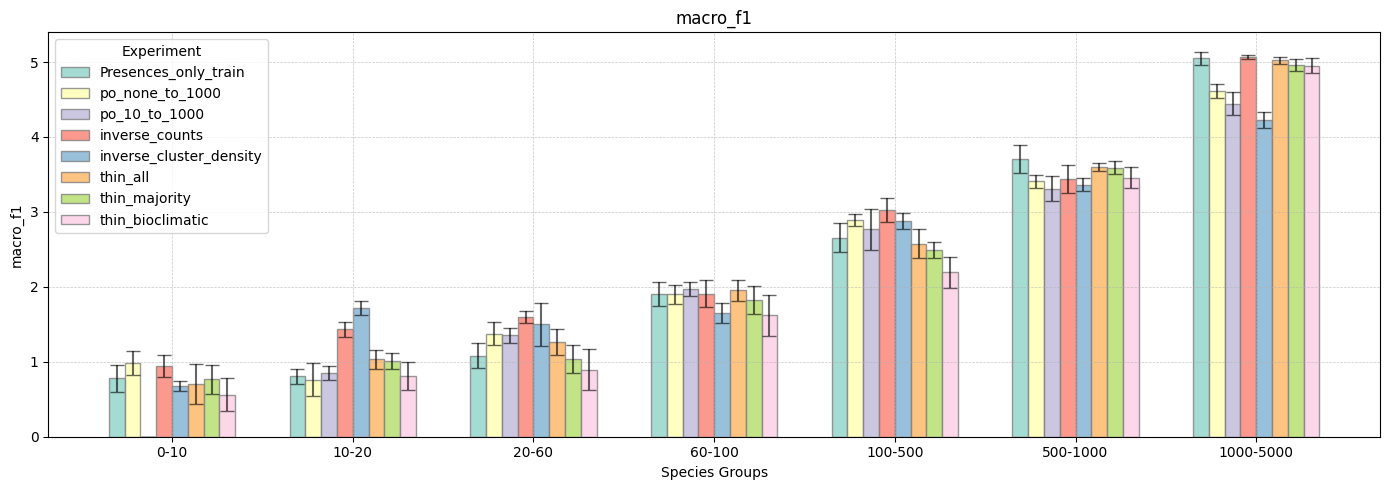

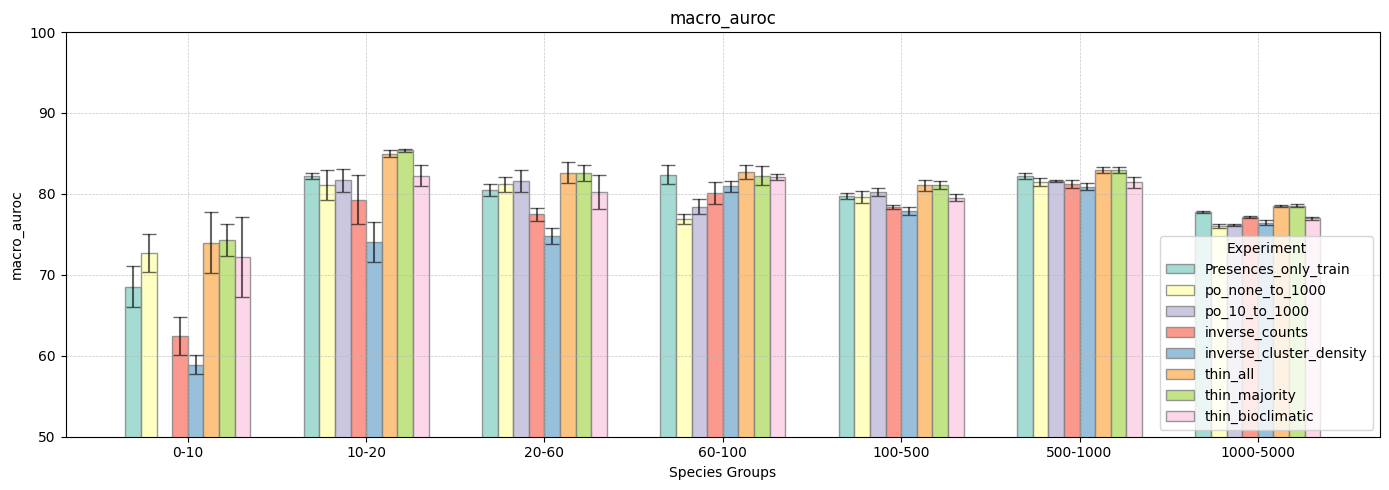

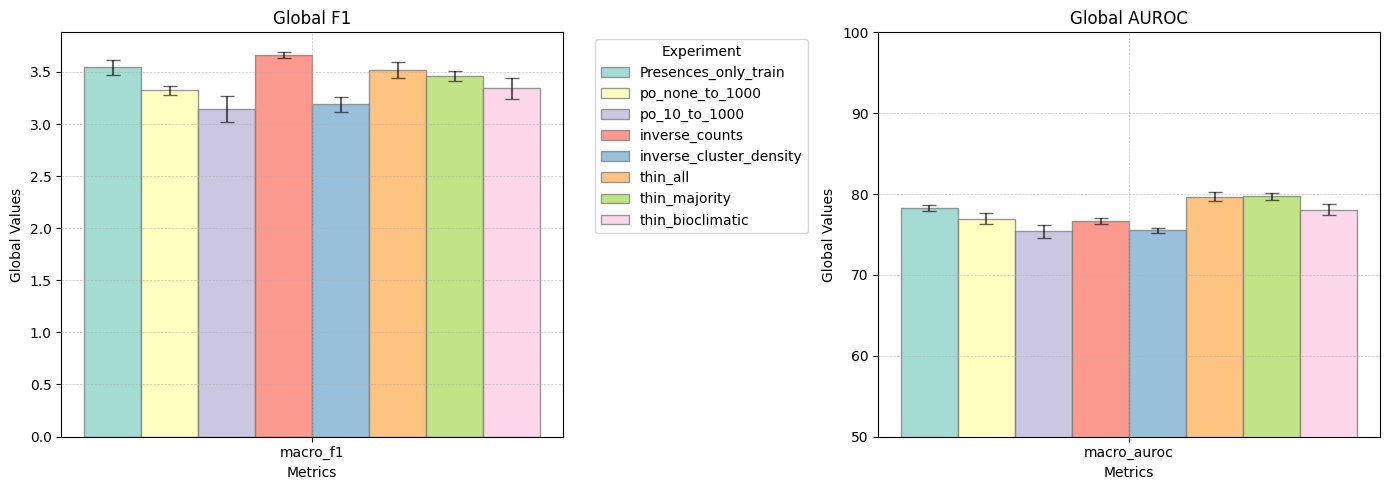

DataFrame for macro_f1:


,0-10,10-20,20-60,60-100,100-500,500-1000,1000-5000,global
Presences_only_train,0.782,0.806,1.08,1.908,2.658,3.704,5.052,3.545479
po_none_to_1000,0.984,0.762,1.372,1.898,2.888,3.406,4.614,3.323541
po_10_to_1000,0.0,0.85,1.352,1.974,2.766,3.312,4.446,3.144332
inverse_counts,0.94,1.432,1.598,1.91,3.028,3.438,5.068,3.664448
inverse_cluster_density,0.676,1.718,1.5,1.652,2.878,3.362,4.224,3.190169
thin_all,0.704,1.032,1.264,1.954,2.574,3.602,5.022,3.519244
thin_majority,0.766,1.01,1.036,1.828,2.492,3.592,4.966,3.460601
thin_bioclimatic,0.562,0.81,0.896,1.618,2.194,3.458,4.952,3.34434
thin_bioclimatic,0.562,0.81,0.896,1.618,2.194,3.458,4.952,3.34434


DataFrame for macro_auroc:


,0-10,10-20,20-60,60-100,100-500,500-1000,1000-5000,global
Presences_only_train,68.552,82.216,80.454,82.39,79.726,82.216,77.736,78.242479
po_none_to_1000,72.66,81.106,81.17,76.928,79.648,81.428,76.028,76.968437
po_10_to_1000,0.0,81.662,81.606,78.412,80.242,81.562,76.16,75.37641
inverse_counts,62.458,79.266,77.508,80.108,78.376,81.254,77.154,76.666101
inverse_cluster_density,58.896,74.074,74.804,80.928,77.892,80.872,76.426,75.534814
thin_all,73.988,84.968,82.636,82.684,81.044,82.944,78.524,79.685626
thin_majority,74.344,85.378,82.578,82.272,81.104,82.93,78.56,79.737926
thin_bioclimatic,72.21,82.264,80.264,82.136,79.53,81.438,77.002,78.082068
thin_bioclimatic,72.21,82.264,80.264,82.136,79.53,81.438,77.002,78.082068


In [4]:
experiments = loc_experiments + env_experiments

full_summary_mean, full_summary_std = read_and_process_data(loc_env_path, experiments, metrics)
plot_values(full_summary_mean, full_summary_std, experiments, metrics, groups)
metric_dataframes = create_metric_dataframes(full_summary_mean, metrics, groups + ["global"], experiments+env_experiments)
# Display the DataFrames
for metric, df in metric_dataframes.items():
    print(f"DataFrame for {metric}:")
    display(df)

In [6]:
full_summary_std

{'Presences_only_train': {'macro_f1': 1000-5000    0.087293
  500-1000     0.190866
  100-500      0.195755
  60-100       0.161771
  20-60        0.166883
  10-20        0.101143
  0-10         0.180472
  global       0.073096
  dtype: float64,
  'macro_auroc': 1000-5000    0.118870
  500-1000     0.388626
  100-500      0.336794
  60-100       1.192833
  20-60        0.737923
  10-20        0.316117
  0-10         2.517016
  global       0.387605
  dtype: float64},
 'po_none_to_1000': {'macro_f1': 1000-5000    0.090167
  500-1000     0.091815
  100-500      0.079812
  60-100       0.125976
  20-60        0.153525
  10-20        0.224878
  0-10         0.159468
  global       0.041597
  dtype: float64,
  'macro_auroc': 1000-5000    0.219249
  500-1000     0.482203
  100-500      0.738830
  60-100       0.602719
  20-60        0.933568
  10-20        1.905644
  0-10         2.338472
  global       0.643869
  dtype: float64},
 'po_10_to_1000': {'macro_f1': 1000-5000    0.149097
  500-10

In [10]:
auroc_means = {}
for key, value in full_summary_mean.items():
    auroc_means[key] = value['macro_auroc']['global']

auroc_stds = {}
for key, value in full_summary_std.items():
    auroc_stds[key] = value['macro_auroc']['global']

In [12]:
f1_means = {}
for key, value in full_summary_mean.items():
    f1_means[key] = value['macro_f1']['global']

f1_stds = {}
for key, value in full_summary_std.items():
    f1_stds[key] = value['macro_f1']['global']

In [15]:
pd.DataFrame([auroc_means, auroc_stds, f1_means, f1_stds], index=["AUROC mean", "AUROC std", "F1 mean", "F1 std"]).T

,AUROC mean,AUROC std,F1 mean,F1 std
Presences_only_train,78.242479,0.387605,3.545479,0.073096
po_none_to_1000,76.968437,0.643869,3.323541,0.041597
po_10_to_1000,75.376410,0.822650,3.144332,0.122506
inverse_counts,76.666101,0.352357,3.664448,0.031069
inverse_cluster_density,75.534814,0.314867,3.190169,0.070145
thin_all,79.685626,0.573792,3.519244,0.081064
thin_majority,79.737926,0.442468,3.460601,0.047460
thin_bioclimatic,78.082068,0.726977,3.344340,0.099615


In [24]:
smote_metrics = pd.read_csv("/data/jribas/repos/sdm_sandbox/data/test_results/loc_env/smote/metrics.csv")
smotetomek_metrics = pd.read_csv("/data/jribas/repos/sdm_sandbox/data/test_results/loc_env/smote_tomek/metrics.csv")

In [26]:
smote_metrics

,loss,f1 micro,f1 macro,auroc_weighted,auroc_macro
0,3.241267,6.505795,3.566684,73.483887,75.095222
1,3.192940,6.595771,3.486362,72.830734,73.508835
2,3.140424,6.532232,3.486689,73.873207,75.931549


In [27]:
smote_metrics["f1 macro"].agg(["mean", "std"])

mean    3.513245
std     0.046280
Name: f1 macro, dtype: float64

In [29]:
smote_metrics["auroc_macro"].agg(["mean", "std"])

mean    74.845202
std      1.230556
Name: auroc_macro, dtype: float64

In [32]:
smotetomek_metrics["f1 macro"].agg(["mean", "std"])

mean    3.350081
std     0.116016
Name: f1 macro, dtype: float64

In [31]:
smotetomek_metrics["auroc_macro"].agg(["mean", "std"])

mean    73.902077
std      1.070324
Name: auroc_macro, dtype: float64

# Effect of dataset size

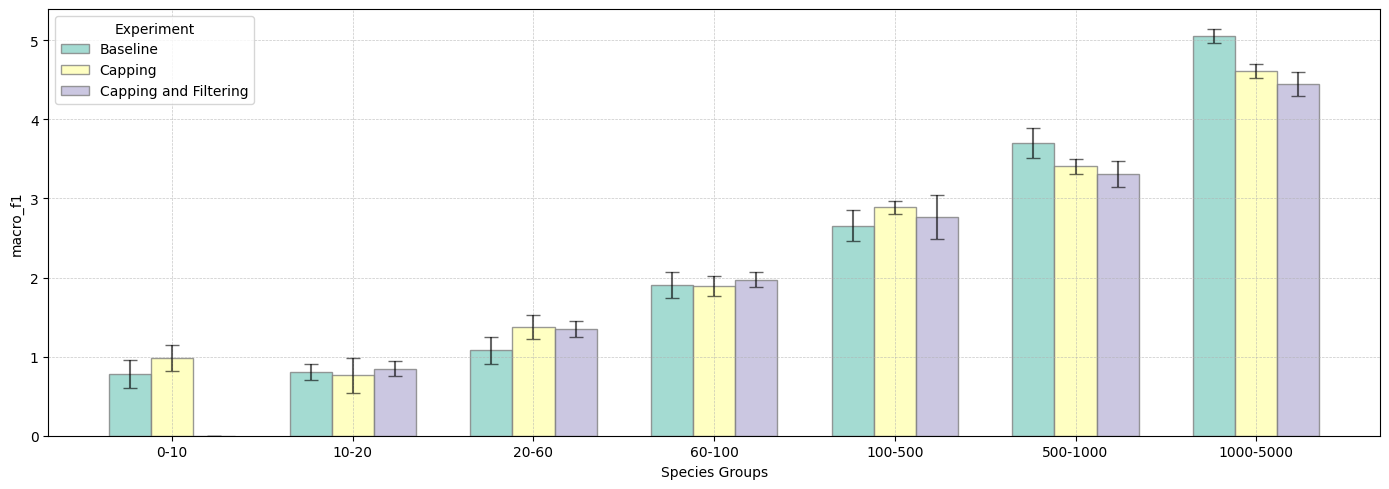

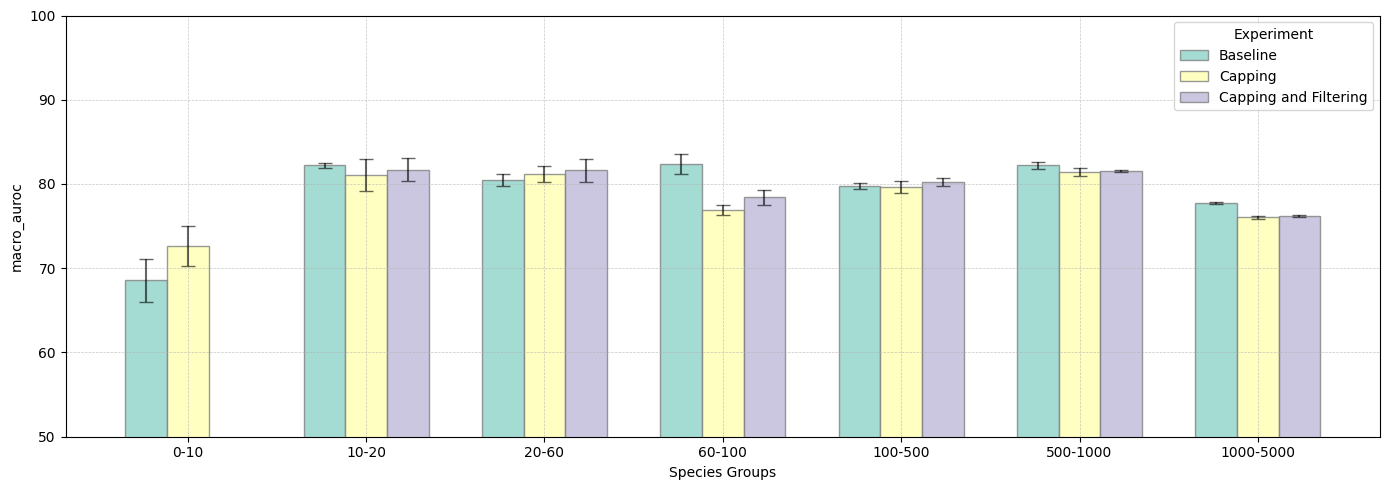

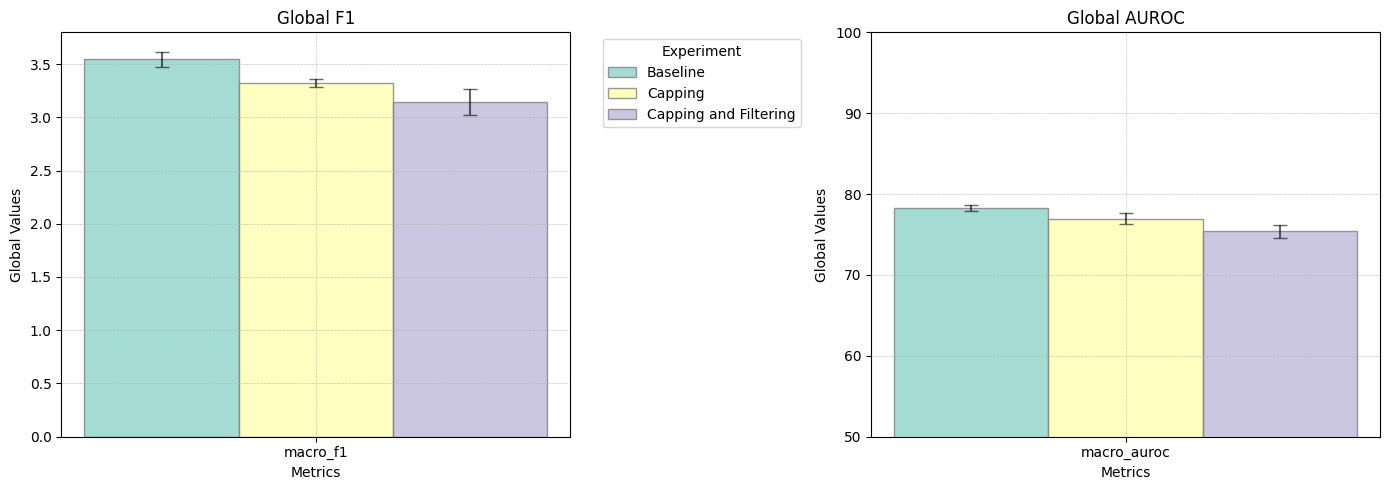

DataFrame for macro_f1:


,0-10,10-20,20-60,60-100,100-500,500-1000,1000-5000,global
Baseline,0.782,0.806,1.08,1.908,2.658,3.704,5.052,3.545479
Capping,0.984,0.762,1.372,1.898,2.888,3.406,4.614,3.323541
Capping and Filtering,0.0,0.85,1.352,1.974,2.766,3.312,4.446,3.144332


DataFrame for macro_auroc:


,0-10,10-20,20-60,60-100,100-500,500-1000,1000-5000,global
Baseline,68.552,82.216,80.454,82.39,79.726,82.216,77.736,78.242479
Capping,72.66,81.106,81.17,76.928,79.648,81.428,76.028,76.968437
Capping and Filtering,0.0,81.662,81.606,78.412,80.242,81.562,76.16,75.37641


In [46]:
experiments = ["Baseline", "Capping", "Capping and Filtering"]
full_summary_mean, full_summary_std = read_and_process_data(loc_env_path, experiments, metrics)
plot_values(full_summary_mean, full_summary_std, experiments, metrics, groups)
metric_dataframes = create_metric_dataframes(full_summary_mean, metrics, groups + ["global"], experiments)
# Display the DataFrames
for metric, df in metric_dataframes.items():
    print(f"DataFrame for {metric}:")
    display(df)

# Thinning strategies

In [13]:
sizes

,Step,Capping and Filetering,Name: loc_env_baseline_ds_po_10_to_1000.csv - train/dataset size__MIN,Name: loc_env_baseline_ds_po_10_to_1000.csv - train/dataset size__MAX,Name: loc_env_smote_data/smotetomek.csv - train/dataset size,Name: loc_env_smote_data/smotetomek.csv - train/dataset size__MIN,Name: loc_env_smote_data/smotetomek.csv - train/dataset size__MAX,Name: loc_env_smote_data/smote.csv - train/dataset size,Name: loc_env_smote_data/smote.csv - train/dataset size__MIN,Name: loc_env_smote_data/smote.csv - train/dataset size__MAX,...,Name: loc_env_wrs_inverse_counts_eps_10_noise_None - train/dataset size__MAX,Complete Thinning,Name: loc_env_thin_all_dist_5 - train/dataset size__MIN,Name: loc_env_thin_all_dist_5 - train/dataset size__MAX,Capping,Name: loc_env_baseline_ds_po_none_to_1000.csv_noise_None - train/dataset size__MIN,Name: loc_env_baseline_ds_po_none_to_1000.csv_noise_None - train/dataset size__MAX,Baseline,Name: loc_env_baseline_ds_Presences_only_train.csv_noise_None - train/dataset size__MIN,Name: loc_env_baseline_ds_Presences_only_train.csv_noise_None - train/dataset size__MAX
0,1,1965051,1965051,1965051,3122287,3122287,3122287,5909987,5909987,5909987,...,4908319,2876815,2876815,2876815,1977559,1977559,1977559,4908319,4908319,4908319


In [ ]:
t

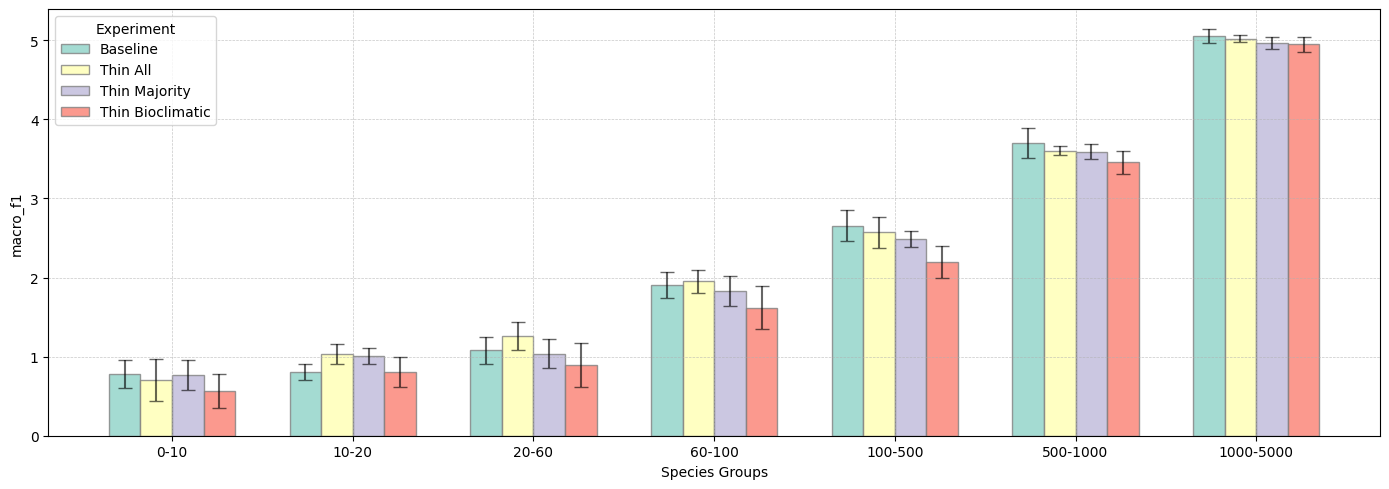

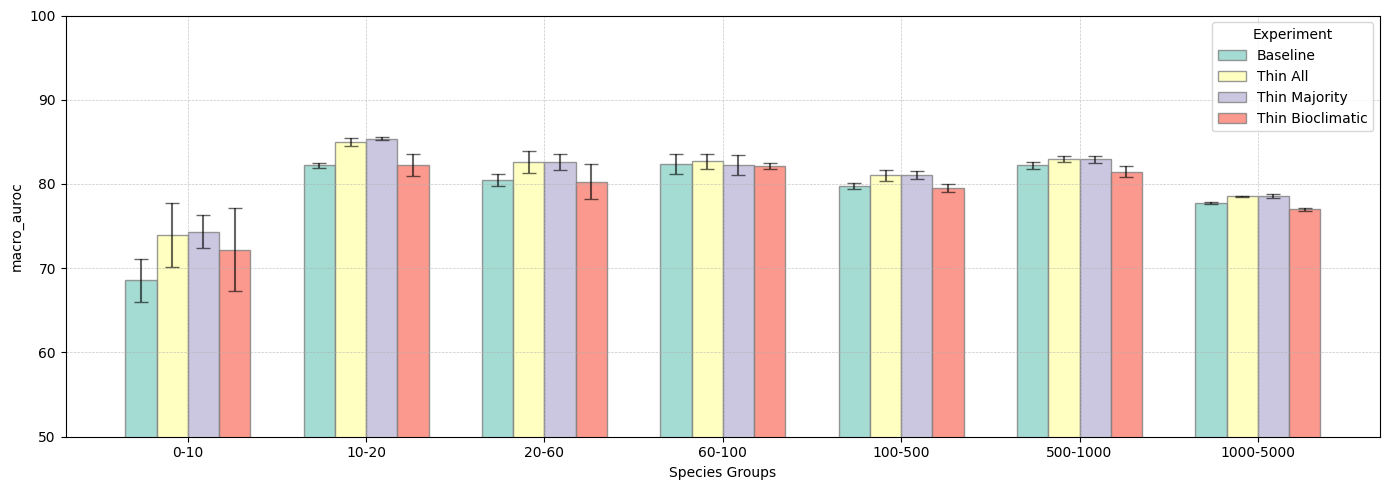

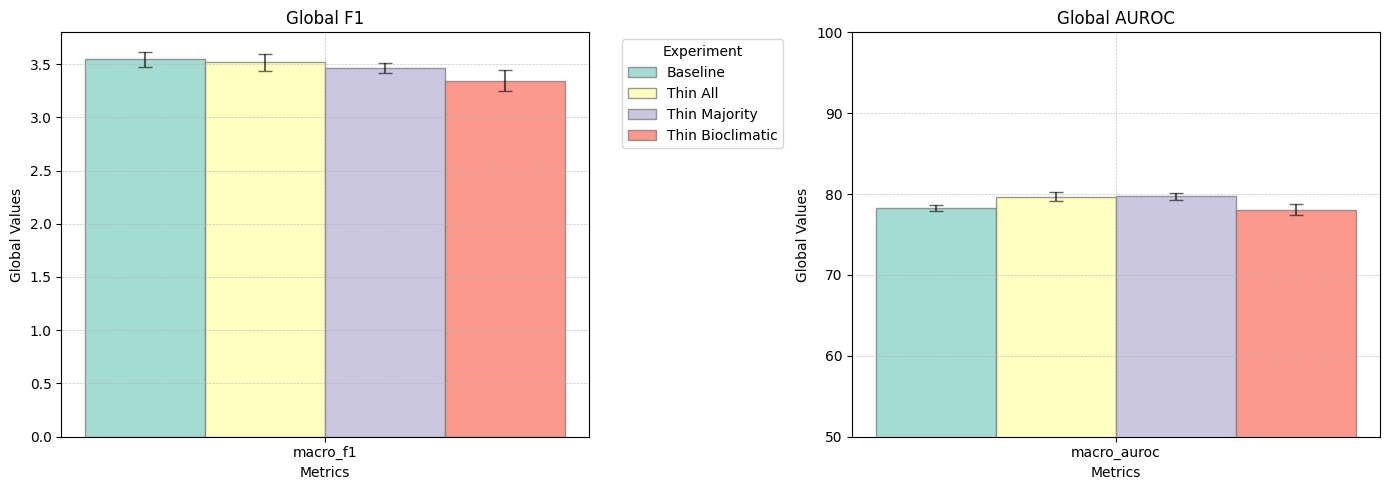

DataFrame for macro_f1:


,0-10,10-20,20-60,60-100,100-500,500-1000,1000-5000,global
Baseline,0.782,0.806,1.08,1.908,2.658,3.704,5.052,3.545479
Thin All,0.704,1.032,1.264,1.954,2.574,3.602,5.022,3.519244
Thin Majority,0.766,1.01,1.036,1.828,2.492,3.592,4.966,3.460601
Thin Bioclimatic,0.562,0.81,0.896,1.618,2.194,3.458,4.952,3.34434


DataFrame for macro_auroc:


,0-10,10-20,20-60,60-100,100-500,500-1000,1000-5000,global
Baseline,68.552,82.216,80.454,82.39,79.726,82.216,77.736,78.242479
Thin All,73.988,84.968,82.636,82.684,81.044,82.944,78.524,79.685626
Thin Majority,74.344,85.378,82.578,82.272,81.104,82.93,78.56,79.737926
Thin Bioclimatic,72.21,82.264,80.264,82.136,79.53,81.438,77.002,78.082068


In [47]:
experiments = ["Baseline"] + thinning_experiments
full_summary_mean, full_summary_std = read_and_process_data(loc_env_path, experiments, metrics)
plot_values(full_summary_mean, full_summary_std, experiments, metrics, groups)
metric_dataframes = create_metric_dataframes(full_summary_mean, metrics, groups+["global"], experiments)
# Display the DataFrames
for metric, df in metric_dataframes.items():
    print(f"DataFrame for {metric}:")
    display(df)

# Sampling

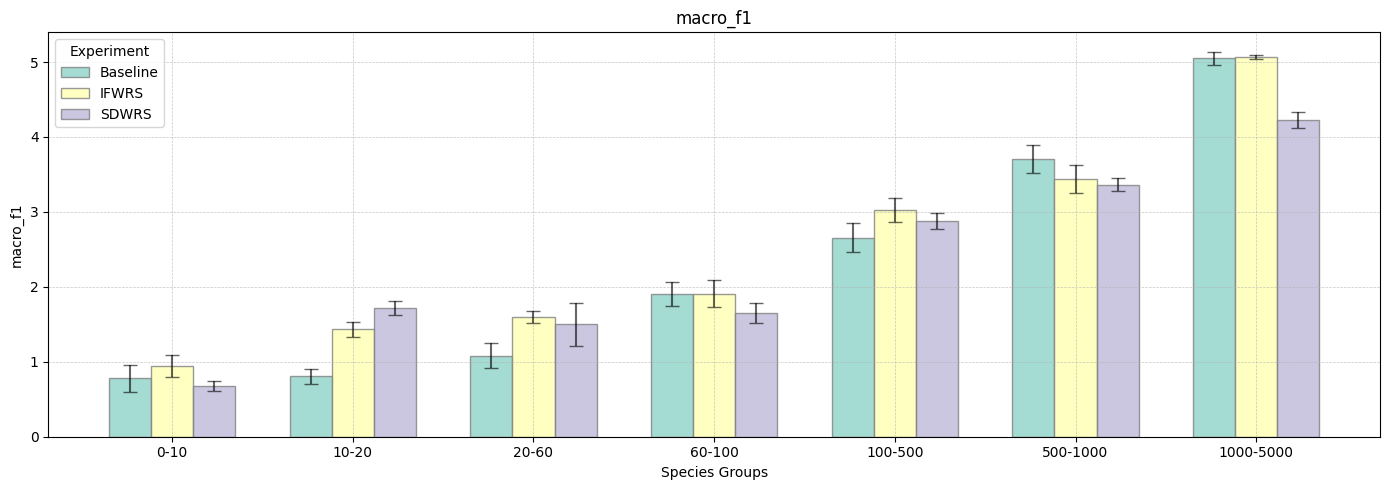

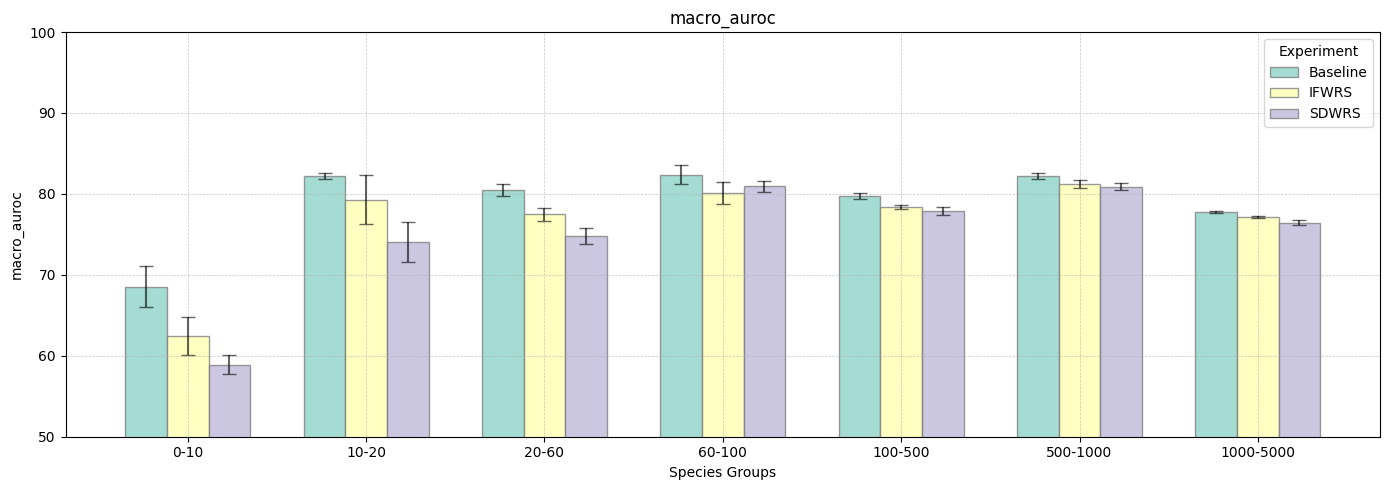

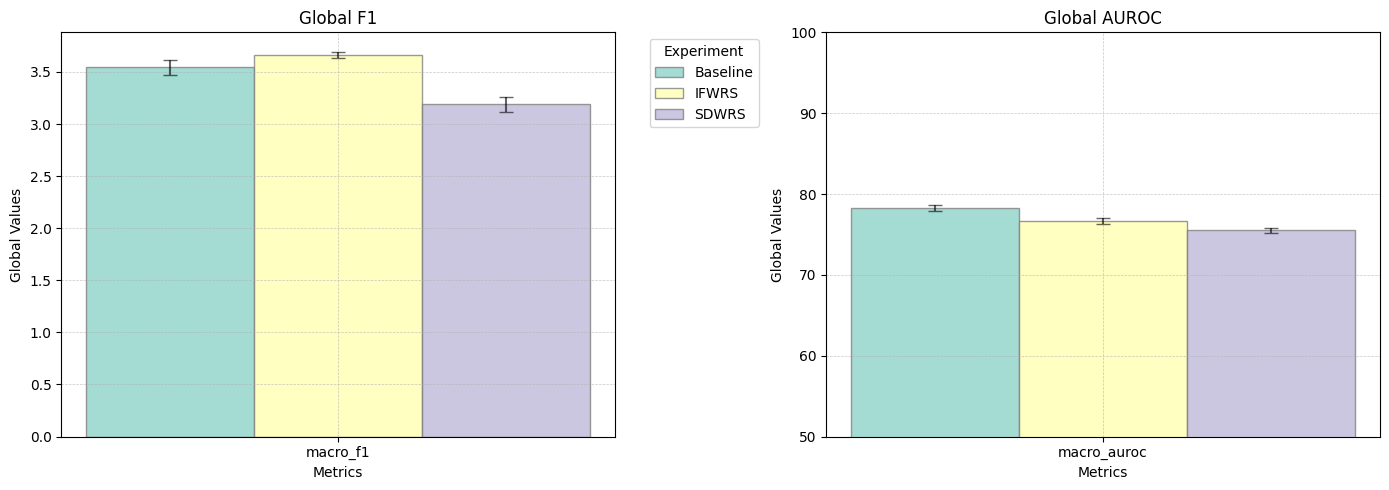

DataFrame for macro_f1:


,0-10,10-20,20-60,60-100,100-500,500-1000,1000-5000,global
Baseline,0.782,0.806,1.08,1.908,2.658,3.704,5.052,3.545479
IFWRS,0.94,1.432,1.598,1.91,3.028,3.438,5.068,3.664448
SDWRS,0.676,1.718,1.5,1.652,2.878,3.362,4.224,3.190169


DataFrame for macro_auroc:


,0-10,10-20,20-60,60-100,100-500,500-1000,1000-5000,global
Baseline,68.552,82.216,80.454,82.39,79.726,82.216,77.736,78.242479
IFWRS,62.458,79.266,77.508,80.108,78.376,81.254,77.154,76.666101
SDWRS,58.896,74.074,74.804,80.928,77.892,80.872,76.426,75.534814


In [44]:
experiments = ["Baseline"] + sampling_experiments
full_summary_mean, full_summary_std = read_and_process_data(loc_env_path, experiments, metrics)
plot_values(full_summary_mean, full_summary_std, experiments, metrics, groups)
metric_dataframes = create_metric_dataframes(full_summary_mean, metrics, groups+["global"], experiments)
# Display the DataFrames
for metric, df in metric_dataframes.items():
    print(f"DataFrame for {metric}:")
    display(df)

In [4]:
po = pd.read_csv("/shares/wegner.ics.uzh/glc23_data/Presences_only_train.csv", sep=";")


In [8]:
species_counts = po["speciesId"].value_counts()


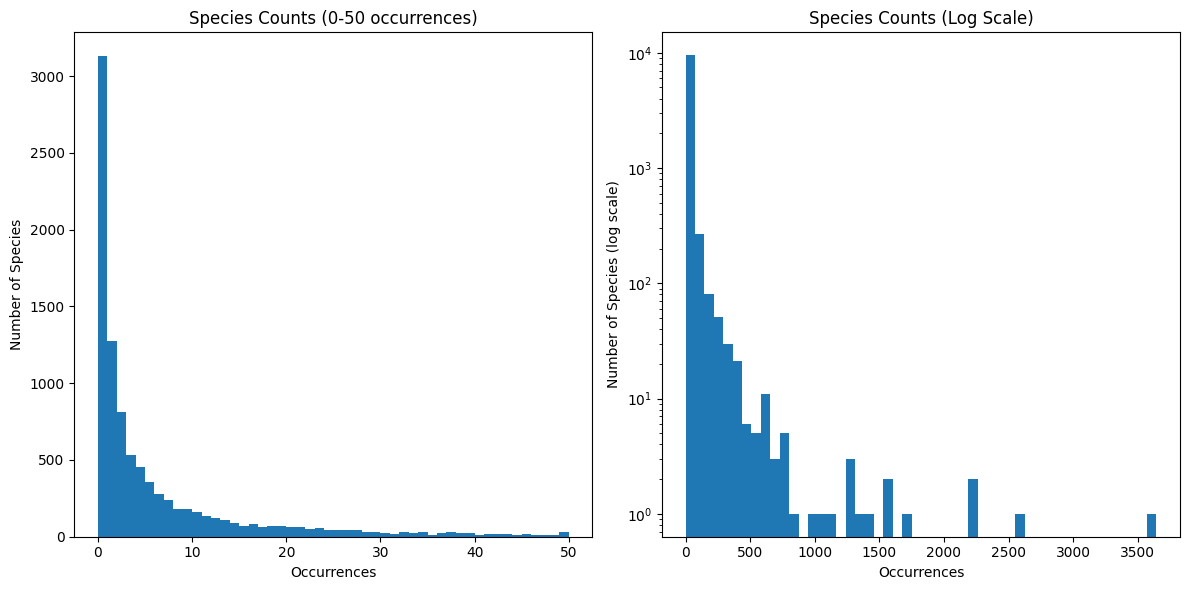

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: assuming 'species_counts' is your data array
species_counts = np.random.lognormal(mean=1, sigma=2, size=10000).astype(int)

# Plot 1: Zoomed in on the lower range
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(species_counts, bins=50, range=(0, 50))
plt.title('Species Counts (0-50 occurrences)')
plt.xlabel('Occurrences')
plt.ylabel('Number of Species')

# Plot 2: Log scale for the full range
plt.subplot(1, 2, 2)
plt.hist(species_counts, bins=50)
plt.yscale('log')
plt.title('Species Counts (Log Scale)')
plt.xlabel('Occurrences')
plt.ylabel('Number of Species (log scale)')

plt.tight_layout()
plt.show()

<Axes: >

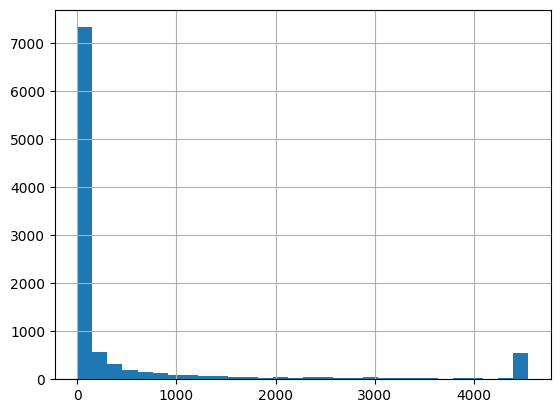

In [6]:
po["speciesId"].value_counts().hist(bins=30)

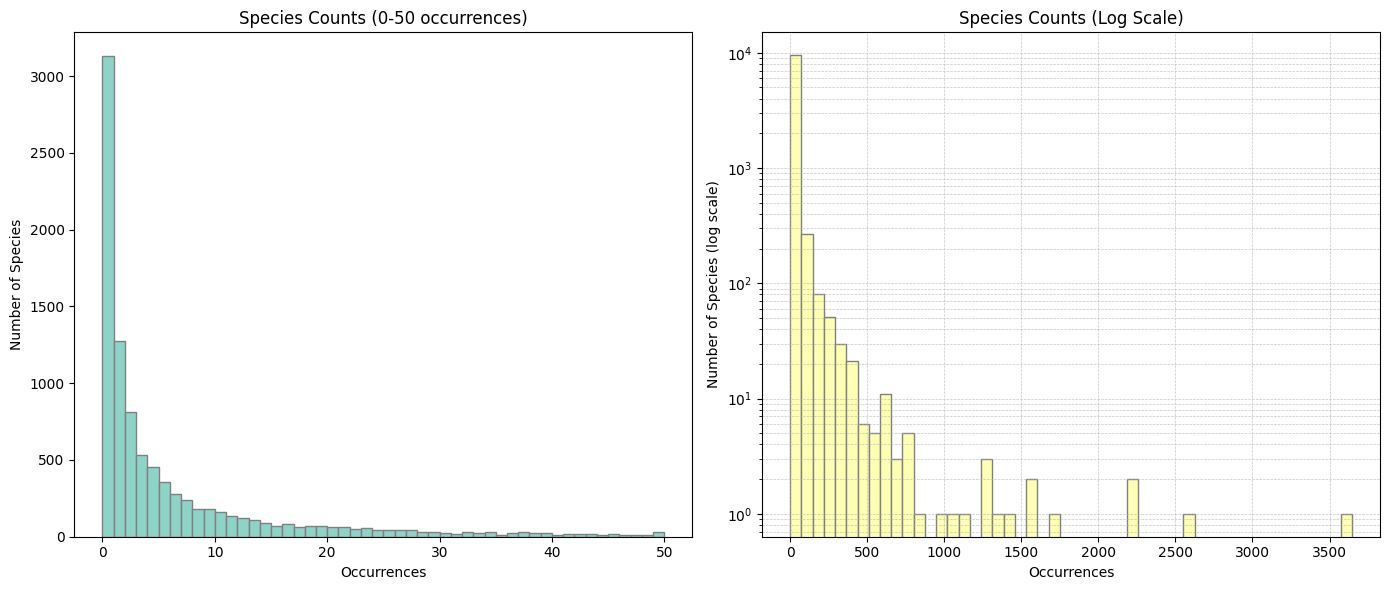

In [11]:
np.random.seed(0)
# Generate a color palette with as many colors as the number of plots needed
colors = plt.get_cmap('Set3').colors

# Plot 1: Zoomed in on the lower range
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(species_counts, bins=50, range=(0, 50), color=colors[0], alpha=1.0, edgecolor='grey')
axes[0].set_title('Species Counts (0-50 occurrences)')
axes[0].set_xlabel('Occurrences')
axes[0].set_ylabel('Number of Species')

# Plot 2: Log scale for the full range
axes[1].hist(species_counts, bins=50, color=colors[1], alpha=1.0, edgecolor='grey')
axes[1].set_yscale('log')
axes[1].set_title('Species Counts (Log Scale)')
axes[1].set_xlabel('Occurrences')
axes[1].set_ylabel('Number of Species (log scale)')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Box Plots instead of Bar Plots

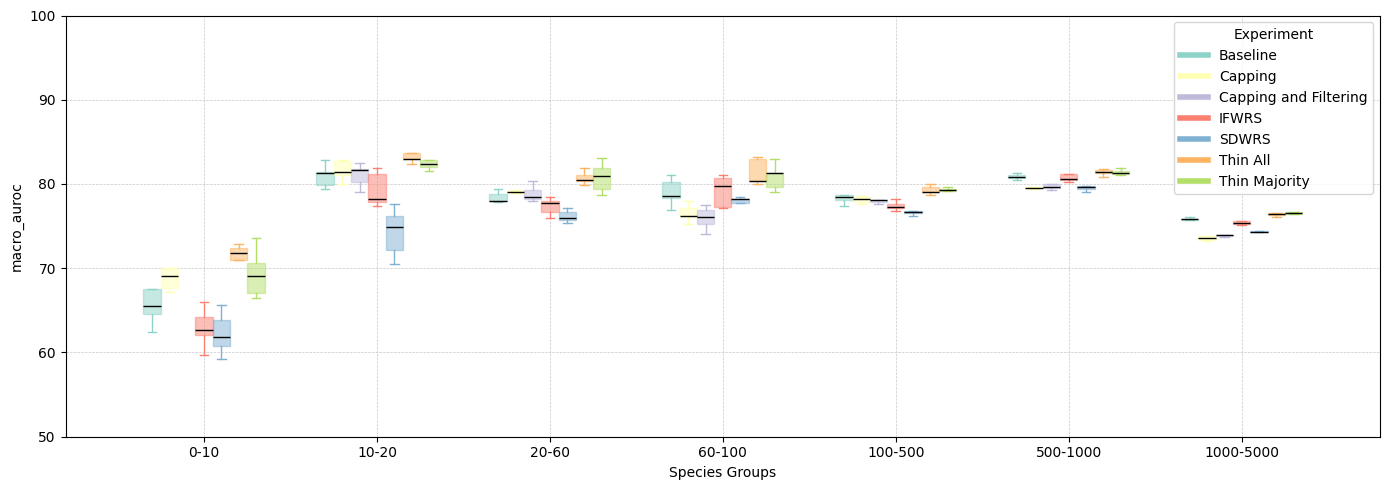

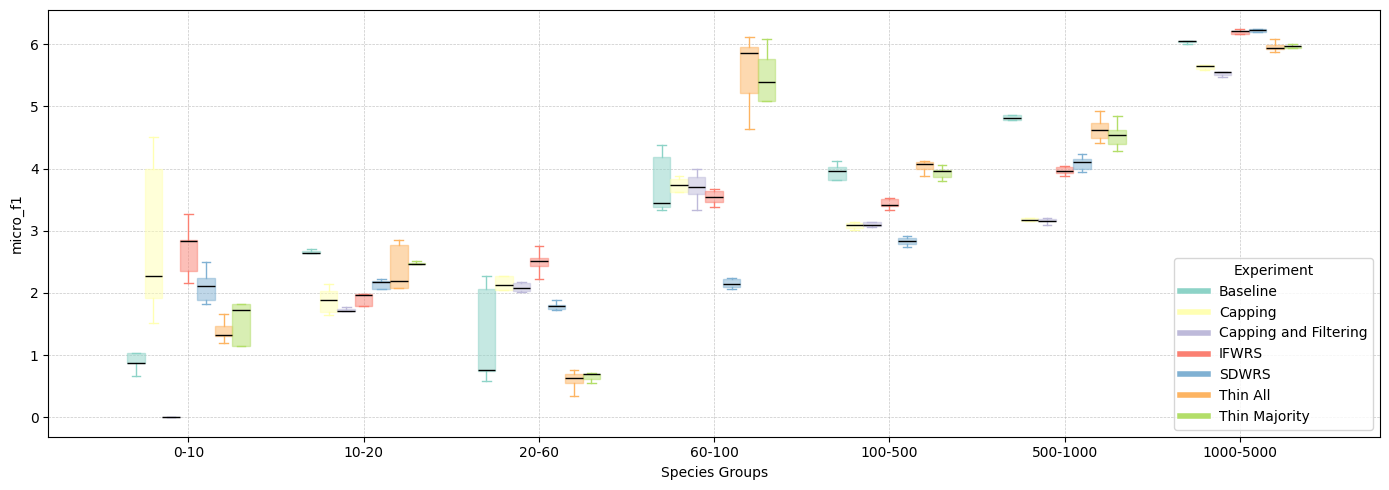

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to read and process data
def read_and_process_data(path, experiments, metrics):
    full_summary = {}
    for experiment in experiments:
        summary = {}
        file_name = rename_experiments[experiment]
        for metric in metrics:
            data = pd.read_csv(f"{path}/{file_name}/{metric}.csv")
            summary[metric] = data
        full_summary[experiment] = summary


    if "Capping and Filtering" in experiments:
        for metric in metrics:
            full_summary["Capping and Filtering"][metric]["0-10"] = 0

    return full_summary

# Function to plot values
def plot_values(full_summary, experiments, metrics, groups, figsize=(14, 5)):
    colors = plt.get_cmap('Set3').colors

    # Function to plot individual group metrics
    def plot_group_metrics(metric, colors, indices):
        fig, ax = plt.subplots(figsize=figsize)
        for i, experiment in enumerate(experiments):
            data = full_summary[experiment][metric]
            data_grouped = [data[group].dropna() for group in groups]
            ax.boxplot(data_grouped, positions=indices + i * (0.7 / len(experiments)), widths=0.7 / len(experiments),
                       patch_artist=True, boxprops=dict(facecolor=colors[i], color=colors[i], alpha=0.5),
                       medianprops=dict(color='black'), whiskerprops=dict(color=colors[i]),
                       capprops=dict(color=colors[i]), flierprops=dict(color=colors[i], markeredgecolor=colors[i]),
                       showfliers=False)

        ax.set_xlabel('Species Groups')
        ax.set_ylabel(metric)
        ax.set_xticks(indices + (0.7 / len(experiments)) * (len(experiments) - 1) / 2)
        ax.set_xticklabels(groups)
        ax.legend([plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(len(experiments))], experiments,
                  title='Experiment')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        # Set y-axis limit for AUROC metrics
        if 'auroc' in metric:
            ax.set_ylim(50, 100)
        plt.tight_layout()
        plt.show()

    # Generate a color palette with as many colors as the number of experiments
    colors = plt.get_cmap('Set3').colors

    indices = np.arange(len(groups))

    # Plot individual group metrics
    for metric in metrics:
        plot_group_metrics(metric, colors, indices)

# Function to create DataFrames for each metric
def create_metric_dataframes(full_summary, metrics, groups, experiments):
    metric_dataframes = {}
    for metric in metrics:
        # Create an empty DataFrame with columns as groups and rows as experiments
        df = pd.DataFrame(index=experiments, columns=groups)
        for experiment in experiments:
            for group in groups:
                df.at[experiment, group] = full_summary[experiment][metric][group].mean()
        metric_dataframes[metric] = df
    return metric_dataframes

# Define your experiments, metrics, groups, and path to data
experiments = ['Baseline', 'Capping', 'Capping and Filtering', 'IFWRS', 'SDWRS', 'Thin All', 'Thin Majority']
metrics = ['macro_auroc', 'micro_f1']
groups = ['0-10', '10-20', '20-60', '60-100', '100-500', '500-1000', '1000-5000']
path = loc_path


rename_experiments = {
    "Baseline": "Presences_only_train",
    "Capping": "po_none_to_1000",
    "Capping and Filtering": "po_10_to_1000",
    "IFWRS": "inverse_counts",
    "SDWRS": "inverse_cluster_density",
    "Thin All": "thin_all",
    "Thin Majority": "thin_majority",
    "Thin Bioclimatic": "thin_bioclimatic"
}

full_summary = read_and_process_data(path, experiments, metrics)
plot_values(full_summary, experiments, metrics, groups)
metric_dataframes = create_metric_dataframes(full_summary, metrics, groups, experiments)
